In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import losses
import time
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
dataDir = r"/home/trojan/Desktop/dimentia/data_10slices/dataset with PGGAN/train"

IMG_SHAPE = 256
num_classes = 2
BS = 16
encoder_epochs = 50
classifier_epochs = 50
AUTO = tf.data.experimental.AUTOTUNE
dropout_rate = 0.2

In [3]:
def lr_schedule(epoch):

    lr = 1e-4 
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 40: # 120
        lr *= 1e-2
    elif epoch > 20: #80
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataDir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(IMG_SHAPE, IMG_SHAPE),
  batch_size=BS,
  shuffle=True)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataDir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(IMG_SHAPE, IMG_SHAPE),
  batch_size=BS,
  shuffle=True)

Found 19677 files belonging to 2 classes.
Using 15742 files for training.
Found 19677 files belonging to 2 classes.
Using 3935 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['AD', 'CN']


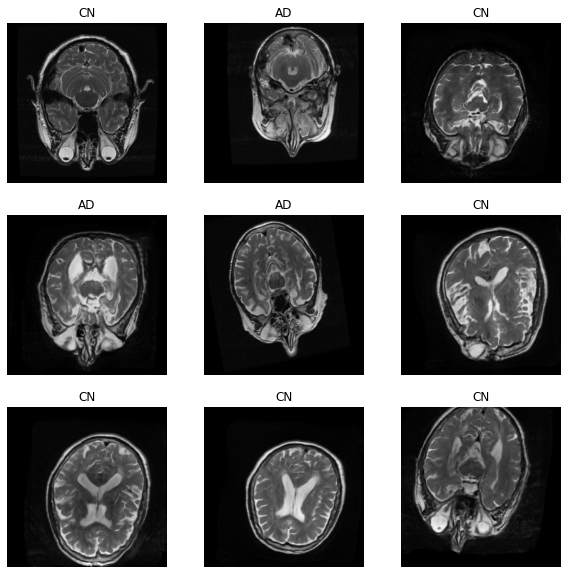

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [8]:
# Data Pipeline

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(image)
    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)


validation_ds = (
    val_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [9]:
# Model Bulding

# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self, **kwargs):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])



In [10]:
normalization_layer = UnitNormLayer()
inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))

In [11]:
cnn_top = Conv2D(32, (5,5), padding='same', activation='relu')(inputs)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Conv2D(512, (3,3), padding='same', activation='relu',)(cnn_top)
cnn_top = BatchNormalization()(cnn_top)
cnn_top = MaxPooling2D(pool_size=(2, 2))(cnn_top)
cnn_top = Flatten()(cnn_top)
cnn_top = Dense(256)(cnn_top)

resized_mid = tf.keras.layers.experimental.preprocessing.Resizing(128, 128, interpolation='bilinear')(inputs)
cnn_mid = Conv2D(32, (5,5), padding='same', activation='relu')(resized_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Conv2D(512, (3,3), padding='same', activation='relu')(cnn_mid)
cnn_mid = BatchNormalization()(cnn_mid)
cnn_mid = MaxPooling2D(pool_size=(2, 2))(cnn_mid)
cnn_mid = Flatten()(cnn_mid)
cnn_mid = Dense(256)(cnn_mid)

resized_bot = tf.keras.layers.experimental.preprocessing.Resizing(64, 64, interpolation='bilinear')(inputs)
cnn_bot = Conv2D(32, (5,5), padding='same', activation='relu')(resized_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(64, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(128, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(256, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Conv2D(512, (3,3), padding='same', activation='relu')(cnn_bot)
cnn_bot = BatchNormalization()(cnn_bot)
cnn_bot = MaxPooling2D(pool_size=(2, 2))(cnn_bot)
cnn_bot = Flatten()(cnn_bot)
cnn_bot = Dense(256)(cnn_bot)

In [12]:
merged_model = concatenate([cnn_top, cnn_mid, cnn_bot])

final_model = Model(inputs, merged_model)

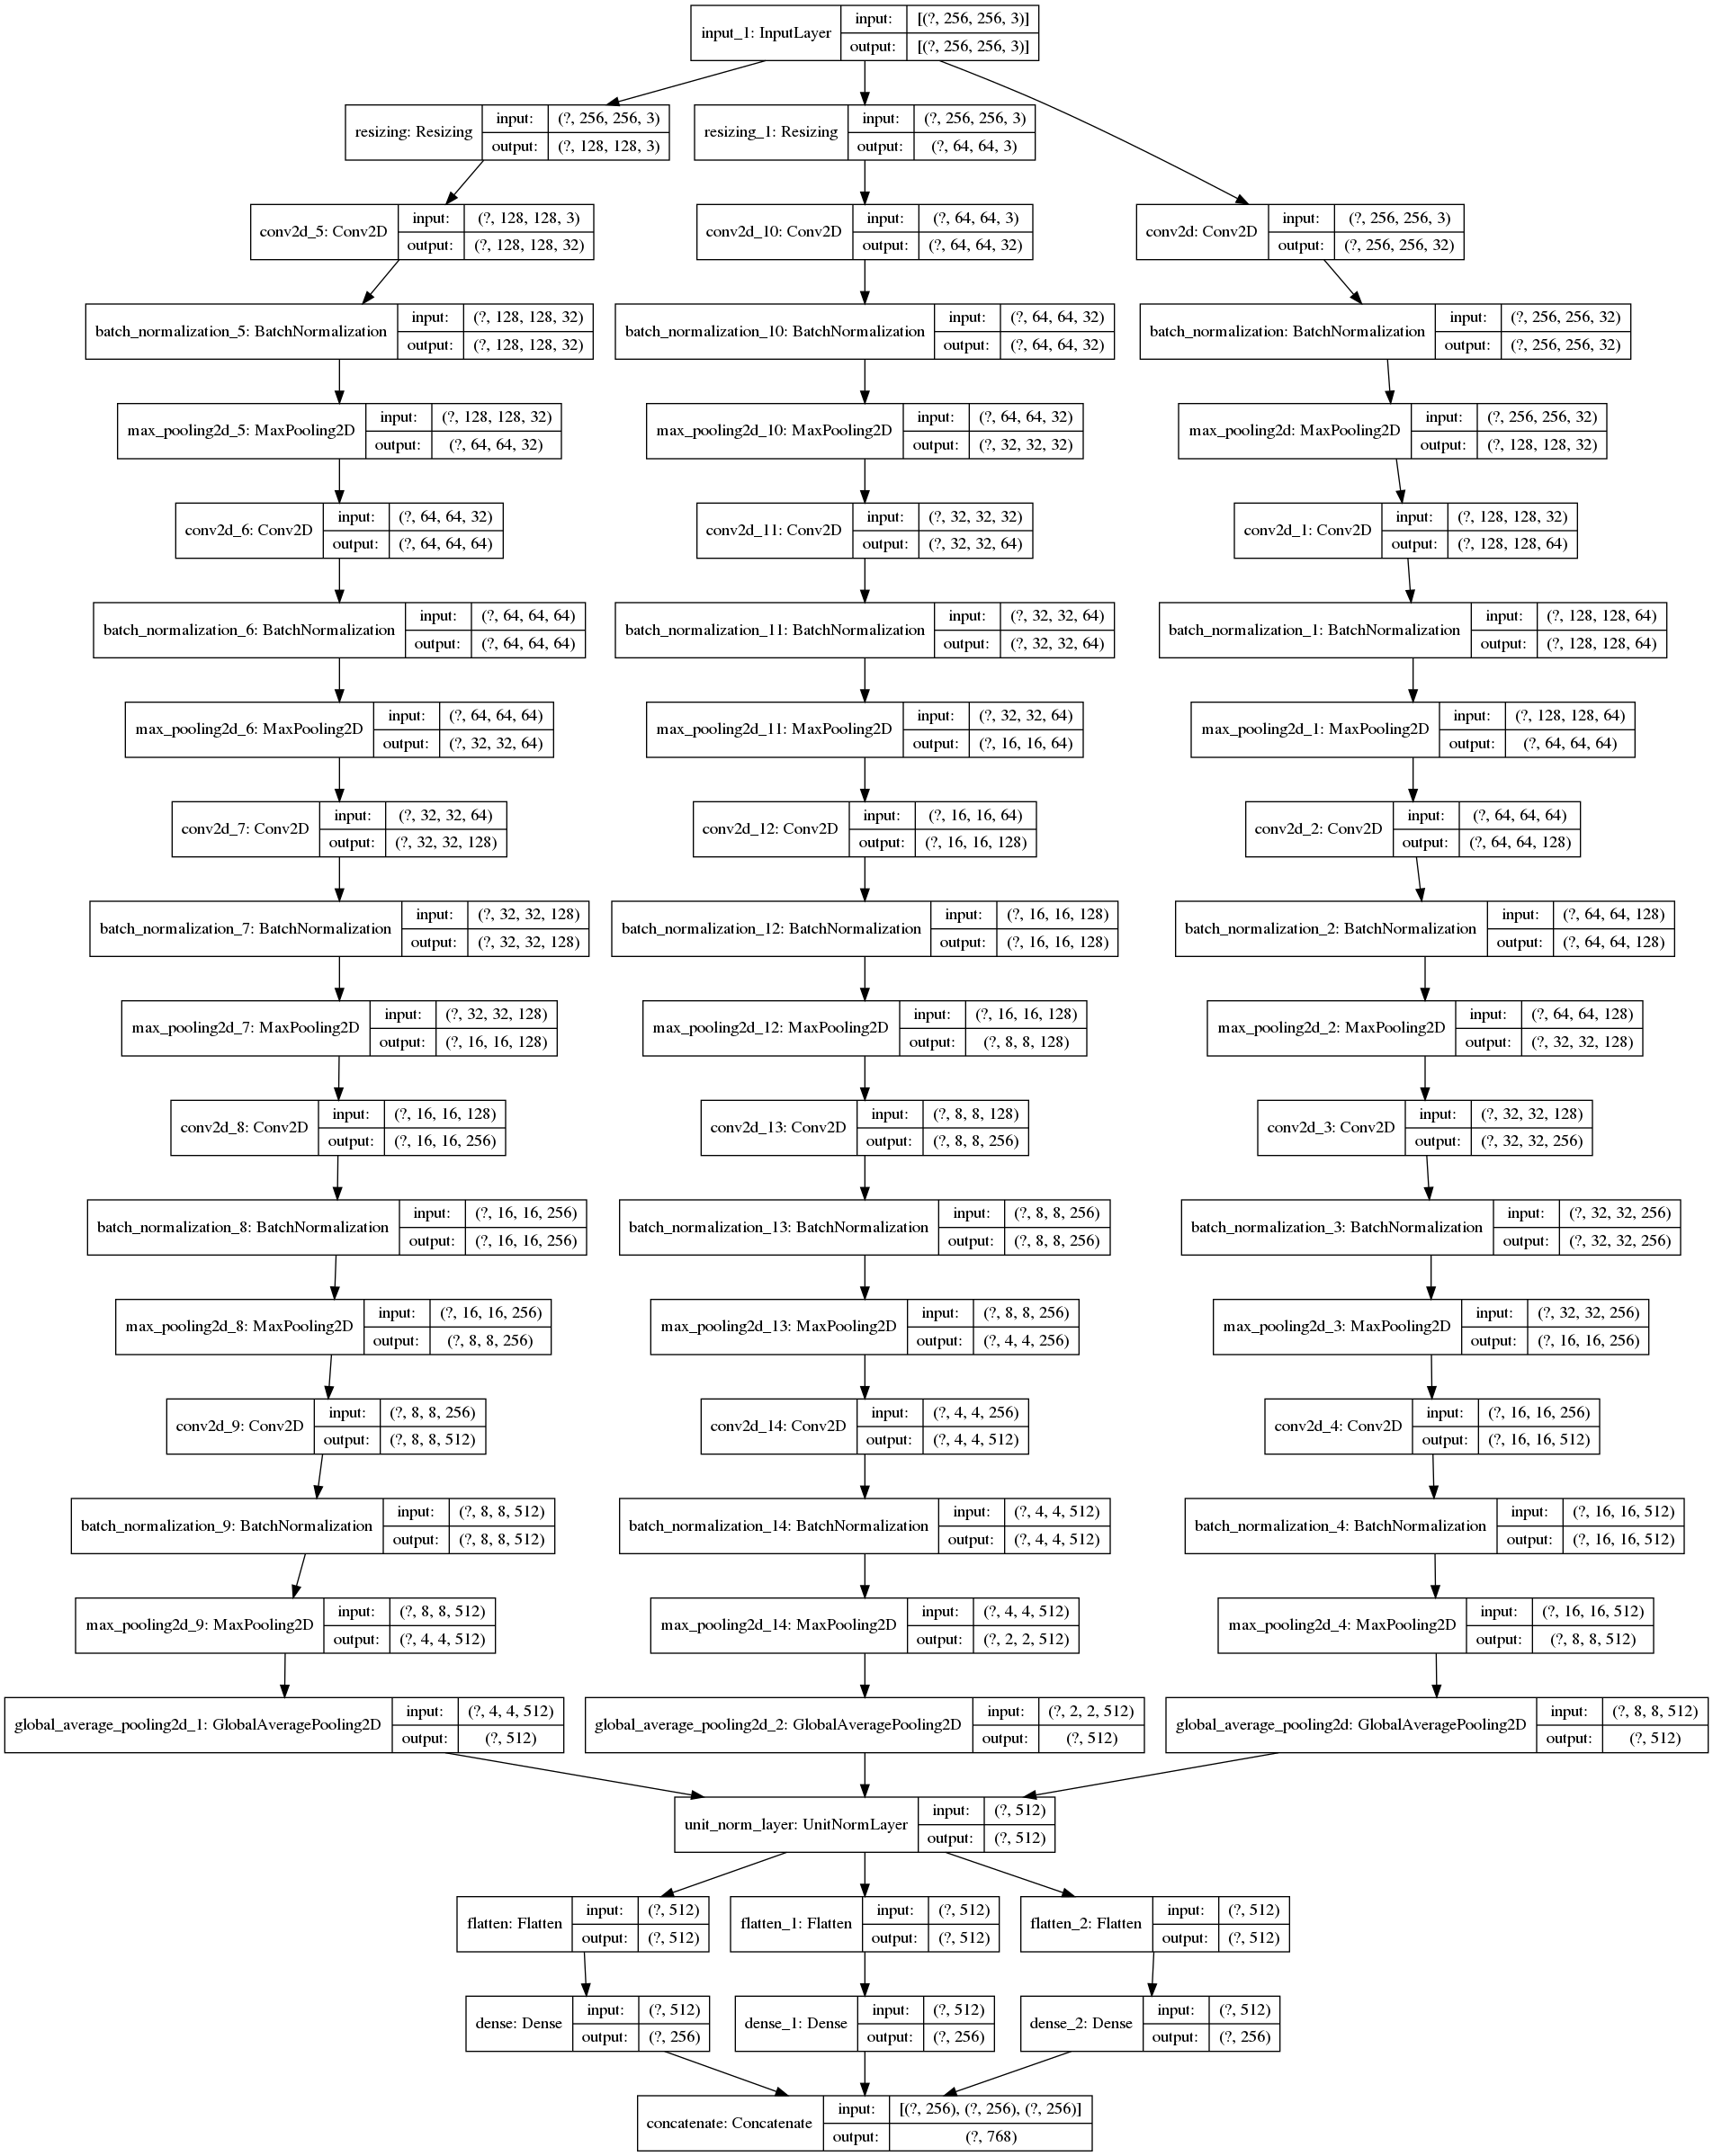

In [13]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

In [14]:
# Encoder Network
def encoder_net():
    inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
    normalization_layer = UnitNormLayer()

    encoder = final_model
    encoder.trainable = True

    embeddings = encoder(inputs, training=True)
    #embeddings = GlobalAveragePooling2D()(embeddings)
    norm_embeddings = normalization_layer(embeddings)

    encoder_network = Model(inputs, norm_embeddings)

    return encoder_network

# Projector Network
def projector_net():
    projector = tf.keras.models.Sequential([
        Dense(256, activation="relu"),
        UnitNormLayer()
])

    return projector

In [15]:
encoder_r = encoder_net()
projector_z = projector_net()

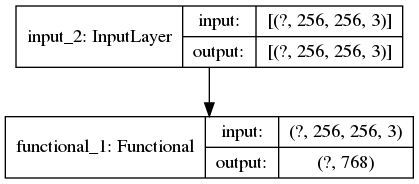

In [16]:
tf.keras.utils.plot_model(encoder_r, show_shapes=True)

In [17]:
#Training encoder and thed projector

optimizer = tf.keras.optimizers.Adam(lr=lr_schedule(0))

encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        r = encoder_r(images, training=True)
        z = projector_z(r, training=True)
        loss = losses.max_margin_contrastive_loss(z, labels)

    gradients = tape.gradient(loss, 
        encoder_r.trainable_variables + projector_z.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
        encoder_r.trainable_variables + projector_z.trainable_variables))

    return loss

Learning rate:  0.0001


Epoch: 0 Loss: 0.196
Epoch Time: 43.112239599227905
Total Time: 43.112239599227905
Epoch: 1 Loss: 0.133
Epoch Time: 39.34185814857483
Total Time: 82.45409774780273
Epoch: 2 Loss: 0.082
Epoch Time: 39.43546104431152
Total Time: 121.88955879211426
Epoch: 3 Loss: 0.044
Epoch Time: 39.61412596702576
Total Time: 161.50368475914001
Epoch: 4 Loss: 0.031
Epoch Time: 39.725468158721924
Total Time: 201.22915291786194
Epoch: 5 Loss: 0.023
Epoch Time: 39.7848162651062
Total Time: 241.01396918296814
Epoch: 6 Loss: 0.020
Epoch Time: 39.99689078330994
Total Time: 281.0108599662781
Epoch: 7 Loss: 0.022
Epoch Time: 39.94872426986694
Total Time: 320.959584236145
Epoch: 8 Loss: 0.023
Epoch Time: 40.029635429382324
Total Time: 360.98921966552734
Epoch: 9 Loss: 0.018
Epoch Time: 40.05802941322327
Total Time: 401.0472490787506
Epoch: 10 Loss: 0.017
Epoch Time: 40.113717794418335
Total Time: 441.16096687316895
Epoch: 11 Loss: 0.013
Epoch Time: 40.16371560096741
Total Time: 481.32468247413635
Epoch: 12 Loss: 

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


Epoch: 49 Loss: nan
Epoch Time: 38.9494514465332
Total Time: 1977.9102787971497


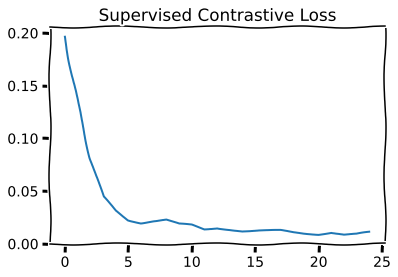

In [18]:
EPOCHS = encoder_epochs
train_loss_results = []

epoch_time = 0
total_time = 0
for epoch in range(EPOCHS):
    start = time.time()
    epoch_loss_avg = tf.keras.metrics.Mean()

    for (images, labels) in train_ds:
        loss = train_step(images, labels)
        epoch_loss_avg.update_state(loss) 

    train_loss_results.append(epoch_loss_avg.result())
    
    print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

    end = time.time()
    epoch_time = end - start
    total_time += epoch_time
    
    print(f"Epoch Time: {epoch_time}")
    print(f"Total Time: {total_time}")
    
with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

In [19]:
encoder_r.save('encoder_model.h5')
projector_z.save('projection_model.h5')

In [20]:
encoder_r = load_model('encoder_model.h5', custom_objects={'UnitNormLayer': UnitNormLayer}, compile=False)

In [21]:
# Supervised training

def supervised_model():
    inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
    encoder_r.trainable = False

    r = encoder_r(inputs, training=False)
    r = layers.Dense(256, activation="relu")(r)
    r = layers.Dropout(dropout_rate)(r)
    r = layers.Dense(128, activation="relu")(r)
    r = layers.Dropout(dropout_rate)(r)
    outputs = Dense(num_classes)(r)

    supervised_model = Model(inputs, outputs)

    return supervised_model

In [22]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=lr_schedule(0)),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


checkpoint = ModelCheckpoint('best_model_contrastive.h5', monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
#es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
    #restore_best_weights=True, verbose=2)

lr_scheduler = LearningRateScheduler(lr_schedule)
    
supervised_classifier.fit(train_ds,
    validation_data=validation_ds,
    epochs=classifier_epochs,
    callbacks=[checkpoint, lr_scheduler])

Learning rate:  0.0001
Learning rate:  0.0001
Epoch 1/50
981/984 [============================>.] - ETA: 0s - loss: 0.6931 - sparse_categorical_accuracy: 0.5039
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.48437, saving model to best_model_contrastive.h5
984/984 [==============================] - 42s 42ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5039 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.4844
Learning rate:  0.0001
Epoch 2/50
980/984 [============================>.] - ETA: 0s - loss: 0.6931 - sparse_categorical_accuracy: 0.5043
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.48437
984/984 [==============================] - 41s 42ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5039 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4844
Learning rate:  0.0001
Epoch 3/50
984/984 [==============================] - ETA: 0s - loss: 0.6931 - sparse_categorical_accuracy: 0.5039
Epoch 00003: val_sparse_categ

Learning rate:  1e-05
Epoch 22/50
980/984 [============================>.] - ETA: 0s - loss: 0.6931 - sparse_categorical_accuracy: 0.5040
Epoch 00022: val_sparse_categorical_accuracy did not improve from 0.48437
984/984 [==============================] - 41s 41ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5039 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.4844
Learning rate:  1e-05
Epoch 23/50
980/984 [============================>.] - ETA: 0s - loss: 0.6931 - sparse_categorical_accuracy: 0.5043
Epoch 00023: val_sparse_categorical_accuracy did not improve from 0.48437
984/984 [==============================] - 41s 42ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5039 - val_loss: 0.6934 - val_sparse_categorical_accuracy: 0.4844
Learning rate:  1e-05
Epoch 24/50
980/984 [============================>.] - ETA: 0s - loss: 0.6931 - sparse_categorical_accuracy: 0.5038
Epoch 00024: val_sparse_categorical_accuracy did not improve from 0.48437
984/984 [=============